<center><b><font size=6>Supervised learning – classification<b><center>

This notebook implements the supervised learning component of the SSH Shell Attack session project. The goal is to classify attack session tactics based on the provided dataset.

0. **Install Dependencies**
1. **Data Splitting**
2. **Baseline Model Implementation**
3. **Hyperparameter Tuning**
4. **Result Analysis**  
5. **Feature Experimentation**

<center><b><font size=5>Install Dependencies<b><center>

In [43]:
!python ../scripts/install_dependencies.py section2

Installing common packages: pandas, pyarrow
Installing Section 2 packages: matplotlib, seaborn, scikit-learn


In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../')

from scripts.data_processing import sampling, split_train_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV


<center><b><font size=5>Data Splitting<b><center>

Split the dataset into training and testing sets.

"Perform a split to segment the dataset into training and test dataset.
If you want to standardize your dataset, fit the scaler on training set and transforming both training
and test. Notice that the sklearn implementation of tf-idf already performs the standardization."

**Steps:**

- Data Loading
- Data Splitting
- Multi-Label Transformation
- Summary

### Load the dataset

- Loads the dataset from a Parquet file into a Pandas DataFrame.

In [45]:
# Dataset intero
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
#SSH_Attacks

In [46]:
SSH_Attacks_bow_sampled = pd.read_parquet("../data/processed/BOW_DATASETS/ssh_attacks_bow_sampled.parquet")
#SSH_Attacks_bow_sampled

In [47]:
SSH_Attacks_tfidf = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf.parquet")
#SSH_Attacks_tfidf_sampled

### Data Splitting

- Define Features (X) and Labels (y)
- Split Data into Training and Testing Sets
- Preprocess Text Data
- Vectorize Text with TF-IDF


_Suggestions:_

- _point 1. Validate that full_session and Set_Fingerprint do not have null values using: print(X.isnull().sum(), y.isnull().sum())_
- _point 2. Stratify the split if the label distribution is imbalanced using: train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)_
- _point 2. Check the distribution of labels in training and test sets._
- _point 3. Add a basic cleaning step if the text contains unwanted characters or casing._
- _point 4. Explore hyperparameters like ngram_range, min_df, and max_df to see their effect on performance._
- _point 4. Use stop_words='english' to remove common but non-informative words._

In [48]:
# Campiona il 5% del dataset
SSH_Attacks_sampled = sampling(SSH_Attacks, 2, 0.05)

# Separazione delle caratteristiche (X) e del target (y)
X = SSH_Attacks_sampled['full_session']  # Text data
y = SSH_Attacks_sampled['Set_Fingerprint']  # Multi-label target

# Ensure a 70/30 split while maintaining reproducibility (random_state=42).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Convert to strings to ensure compatibility with TfidfVectorizer
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Vectorize the text data using TF-IDF (standardization is included in TF-IDF by default)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Controllo delle dimensioni dei dati vettorizzati
print(f"Train set TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test set TF-IDF shape: {X_test_tfidf.shape}")

Train set TF-IDF shape: (8172, 63)
Test set TF-IDF shape: (3503, 63)


### Multi-Label Transformation

- Transform Labels to Binary Format


_Suggestions:_

- _Check for any inconsistencies in label transformation: print(y_train_binary.head(), y_test_binary.head())_
- _Verify that `mlb.classes` matches the expected categories._

In [49]:
# Fit the MultiLabelBinarizer on the training set labels only
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Transform the training and test labels into binary matrices
y_train_binary = pd.DataFrame(mlb.transform(y_train), columns=mlb.classes_, index=y_train.index)
y_test_binary = pd.DataFrame(mlb.transform(y_test), columns=mlb.classes_, index=y_test.index)


### Summary

- Ensures the processed data is correctly prepared for modeling.


_Suggestions:_

- _Check the sparsity of X_train_tfidf and X_test_tfidf: print("Train Sparsity:", (X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)) * 100) print("Test Sparsity:", (X_test_tfidf.nnz / np.prod(X_test_tfidf.shape)) * 100)_

In [50]:
# Print basic info about the processed data
print("\nProcessed Training set size:", len(X_train))
print("\nProcessed Testing set size:", len(X_test))
print("\nShape of y_train_binary:", y_train_binary.shape)
print("\nShape of y_test_binary:", y_test_binary.shape)
print("\nClasses:", mlb.classes_)


Processed Training set size: 8172

Processed Testing set size: 3503

Shape of y_train_binary: (8172, 7)

Shape of y_test_binary: (3503, 7)

Classes: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


<center><b><font size=5>Baseline Model Implementation<b><center>

Train at least two ML models and evaluate their performance.

"Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?"

**Steps:**

- Choose different ML models (e.g., Logistic Regression and Random Forest).
- Logistic Regression - Training and Evaluation.
- Random Forest - Training and Evaluation.
- Support Vector Machine (SVM) - Training and Evaluation.
- Compare performance and check for overfitting/underfitting.

### Choose and initialize models

- text

In [51]:
# Initialize models with default parameters
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),  # Logistic Regression model
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42), # Random Forest with 100 estimators
    "SVM": SVC(kernel='linear', random_state=42)                                # Support Vector Machine with linear kernel
}

# Store results for comparison
model_results = {}


In [52]:
def train_and_evaluate(model, model_name, X_train, X_test, y_train_binary, y_test_binary):
    """
    Train a given model for each label and evaluate its performance.
    
    Args:
        model: An initialized ML model.
        model_name: Name of the model (string).
        X_train, X_test: TF-IDF-transformed training and test data.
        y_train_binary, y_test_binary: Binary label data for training and testing.
    
    Returns:
        results: A dictionary containing classification reports and confusion matrices for all labels.
    """
    results = {}
    
    # Create an empty DataFrame to store predictions for multilabel compatibility
    y_pred = pd.DataFrame(index=y_test_binary.index, columns=y_test_binary.columns)
    
    # Configura la griglia di subplots per la matrice di confusione
    num_labels = len(y_train_binary.columns)
    num_cols = 3  # Numero di colonne nella griglia
    num_rows = (num_labels + num_cols - 1) // num_cols  # Calcola il numero di righe
    
    # Initialize the plot with a grid of subplots (3 rows, 3 columns)
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))  # Adjusted figsize for better spacing
    axes = axes.flatten()  # Flatten to make it easier to access individual axes
    
    # Train and evaluate for each label
    for i, label in enumerate(y_train_binary.columns):
        
        print(f"\n{'='*69}\n  TRAINING FOR LABEL: {label} ({model_name})\n{'='*69}\n")
        
        # Train the model for the current label
        model.fit(X_train, y_train_binary[label])
        
        # Save predictions for both training and test set
        y_train_pred = model.predict(X_train)
        y_pred[label] = model.predict(X_test)
        
        # Store the predictions for the current label
        results[label] = {
            "train_predictions": y_train_pred,
            "test_predictions": y_pred[label],
        }
        
        # Generate and store classification report
        report = classification_report(
            y_test_binary[label], 
            y_pred[label], 
            zero_division=0, # To avoid the warning for precision and F-score.
        )
        results[label]["classification_report"] = report
        
        # Display classification report
        print(f"\nClassification Report for {label}:\n")
        print(report)
        
        # Generate and display confusion matrix
        print(f"Confusion Matrix for {label}:\n")
        cm = confusion_matrix(y_test_binary[label], y_pred[label])
        results[label]["confusion_matrix"] = cm
        
        # Plot the confusion matrix with improved aesthetics
        ax = axes[i]  # Access the i-th subplot
        
        sns.set(font_scale=1.3)  # Adjust font size for better readability
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"],
            annot_kws={"size": 14, "weight": 'bold'}, linewidths=1.2, linecolor='gray', ax=ax
        )
        
        ax.set_title(f"Confusion Matrix for {label} - {model_name}", fontsize=15, weight='bold')
        ax.set_ylabel('True Label', fontsize=15)
        ax.set_xlabel('Predicted Label', fontsize=15)
        
        # Customize tick params for readability
        ax.tick_params(axis='both', labelsize=15)
        
        # Set axis labels in a larger font and remove unnecessary gridlines
        ax.yaxis.set_tick_params(width=1.2)
        ax.xaxis.set_tick_params(width=1.2)
    
    # Remove the extra empty subplot (if any)
    for j in range(num_labels, len(axes)):
        fig.delaxes(axes[j])  # Delete the last empty axis if there are fewer than 9 labels

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
    return results


### Logistic Regression

- Training
- Evaluation (confusion matrix and classification report)


Training and Evaluating: Logistic Regression

  TRAINING FOR LABEL: Defense Evasion (Logistic Regression)


Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3229
           1       0.98      0.96      0.97       274

    accuracy                           1.00      3503
   macro avg       0.99      0.98      0.98      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Defense Evasion:


  TRAINING FOR LABEL: Discovery (Logistic Regression)


Classification Report for Discovery:

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        14
           1       1.00      1.00      1.00      3489

    accuracy                           1.00      3503
   macro avg       1.00      0.71      0.80      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Discovery:


  TRAINING FOR LABEL: Exe

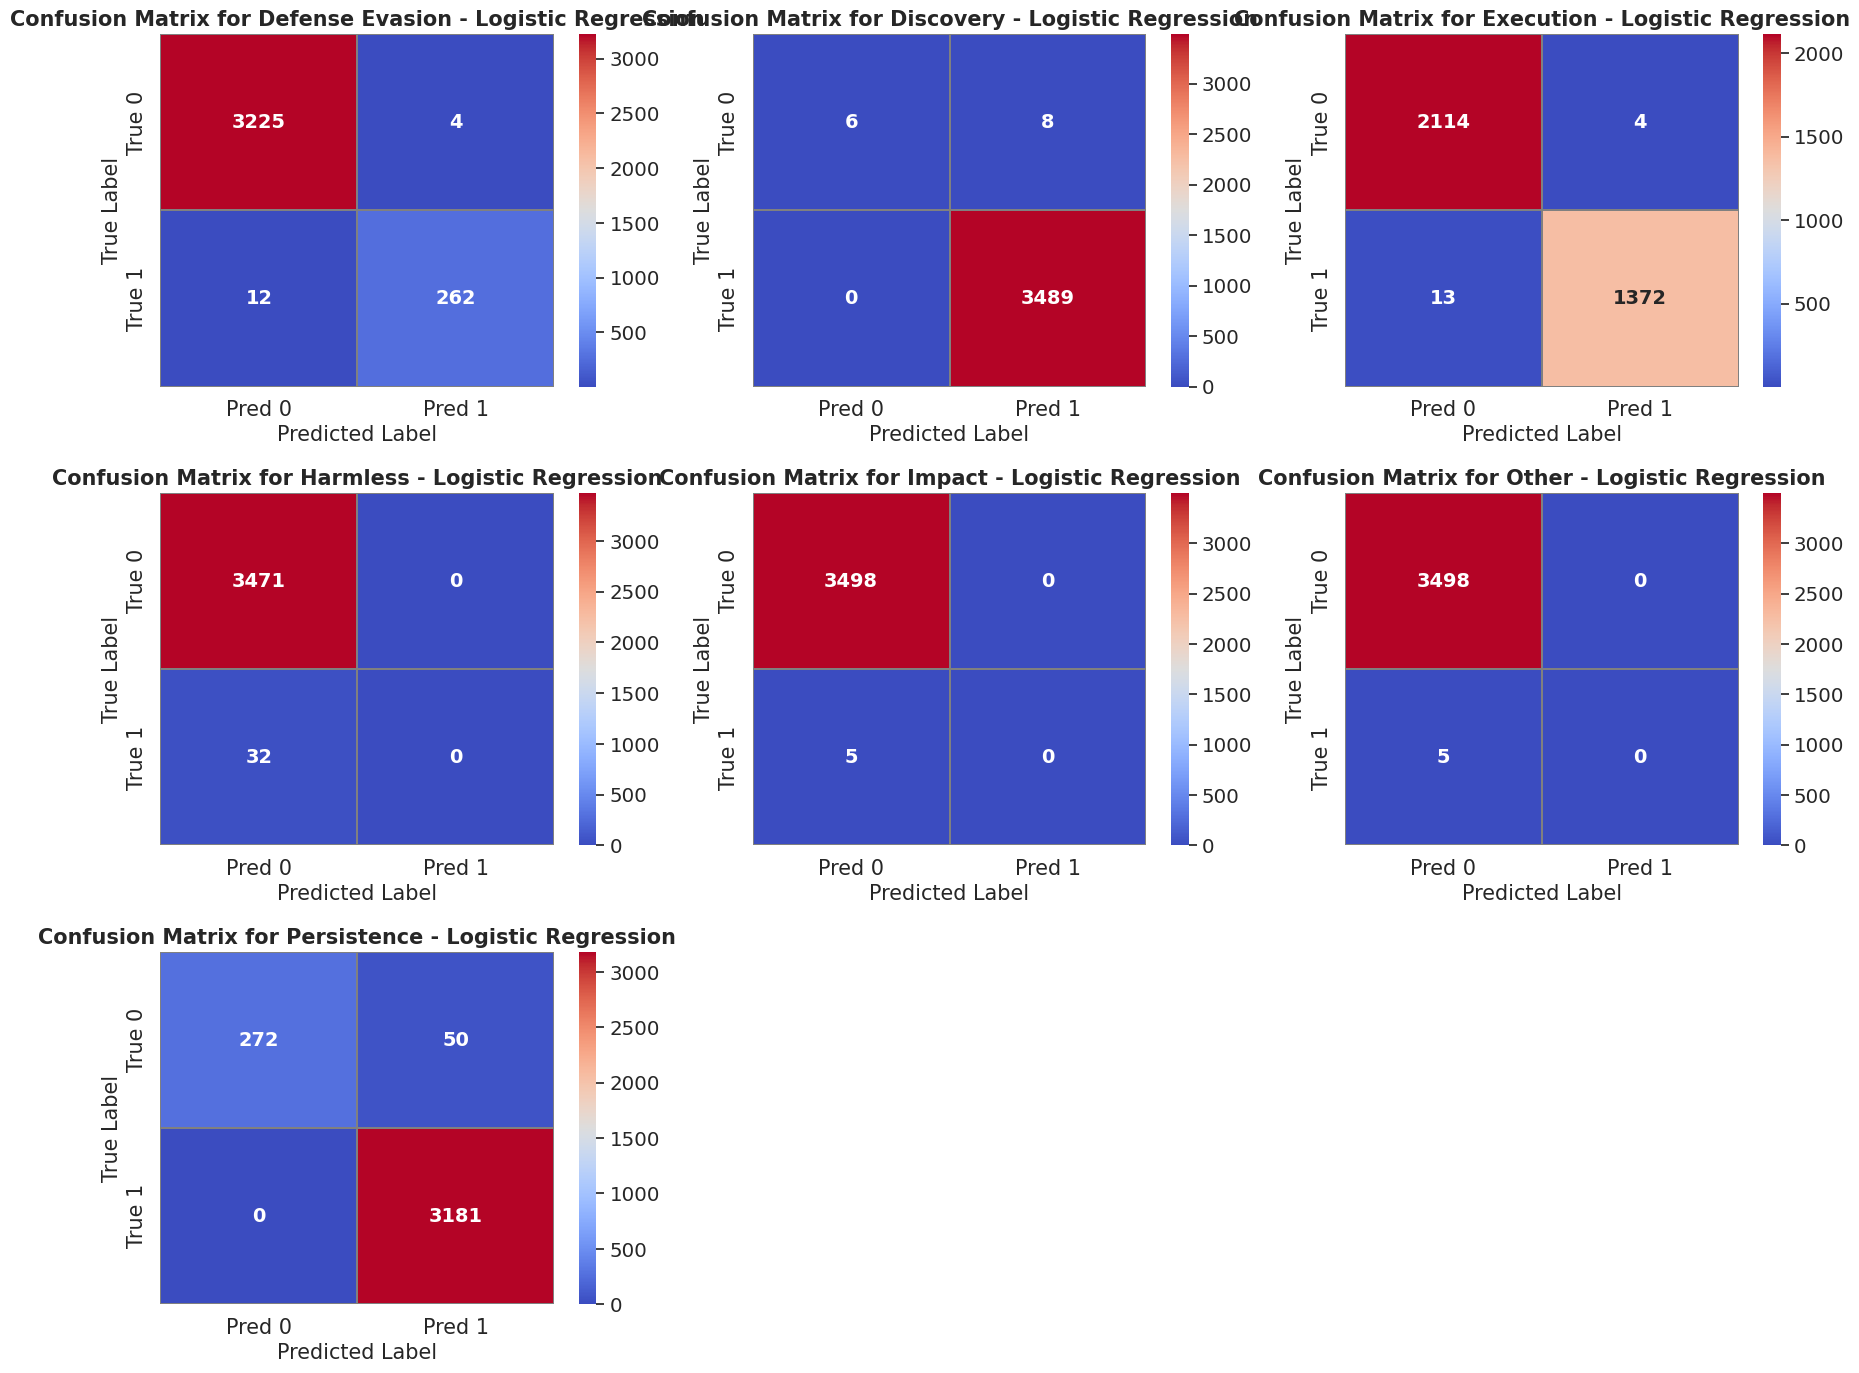

In [53]:
# Train and evaluate Logistic Regression
model_name = "Logistic Regression"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Random Forest

- Training
- Evaluation (confusion matrix and classification report)


Training and Evaluating: Random Forest

  TRAINING FOR LABEL: Defense Evasion (Random Forest)


Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3229
           1       0.98      0.96      0.97       274

    accuracy                           1.00      3503
   macro avg       0.99      0.98      0.98      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Defense Evasion:


  TRAINING FOR LABEL: Discovery (Random Forest)


Classification Report for Discovery:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       1.00      1.00      1.00      3489

    accuracy                           1.00      3503
   macro avg       0.96      0.96      0.96      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Discovery:


  TRAINING FOR LABEL: Execution (Random For

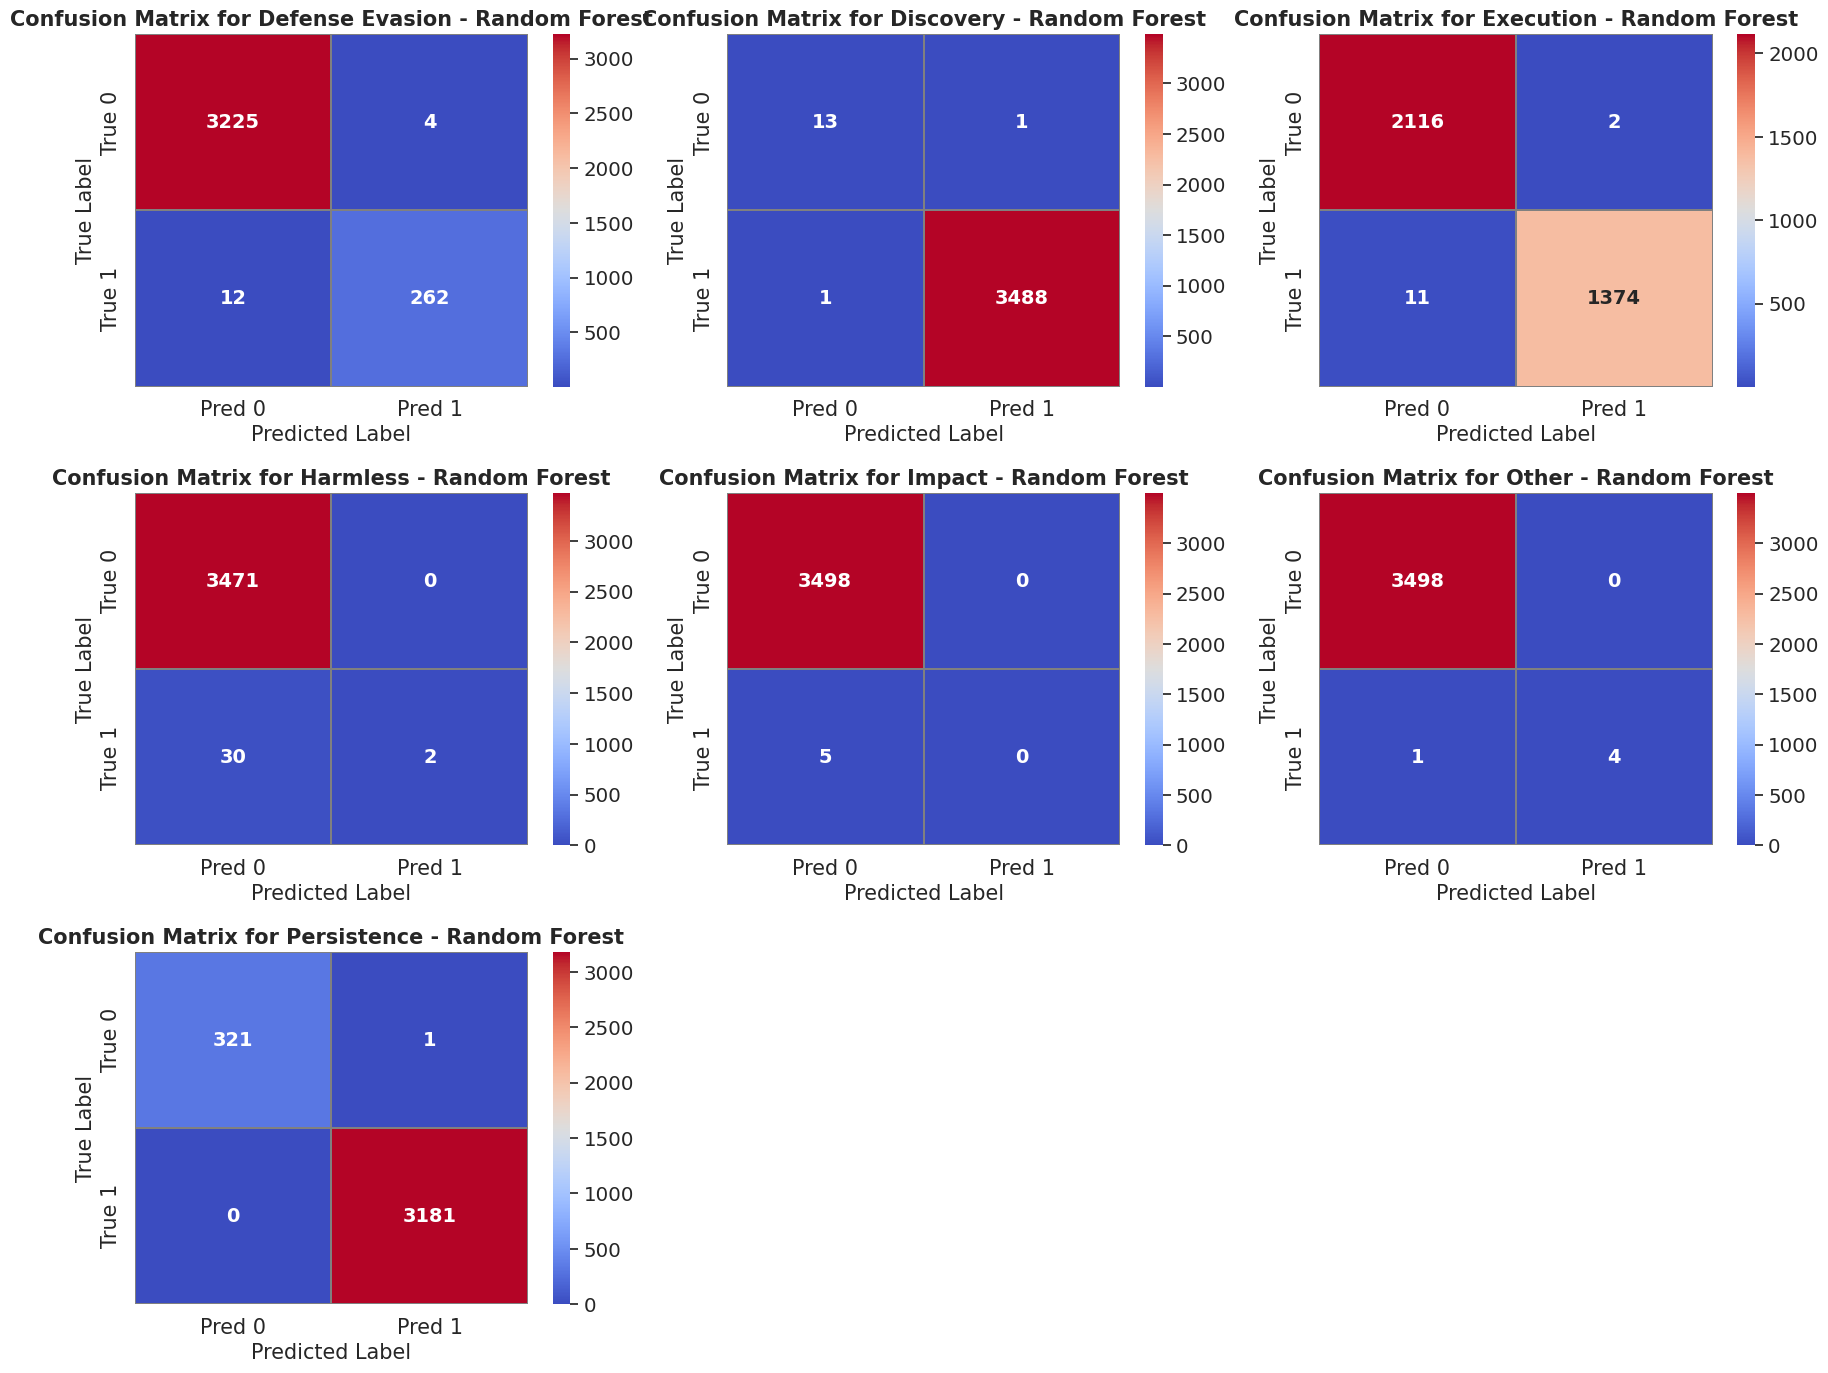

In [54]:
# Train and evaluate Random Forest
model_name = "Random Forest"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Support Vector Machine (SVM)

- Training
- Evaluation (confusion matrix and classification report)


Training and Evaluating: SVM

  TRAINING FOR LABEL: Defense Evasion (SVM)


Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3229
           1       0.99      0.96      0.97       274

    accuracy                           1.00      3503
   macro avg       0.99      0.98      0.98      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Defense Evasion:


  TRAINING FOR LABEL: Discovery (SVM)


Classification Report for Discovery:

              precision    recall  f1-score   support

           0       0.71      0.86      0.77        14
           1       1.00      1.00      1.00      3489

    accuracy                           1.00      3503
   macro avg       0.85      0.93      0.89      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Discovery:


  TRAINING FOR LABEL: Execution (SVM)


Classification Report for Executi

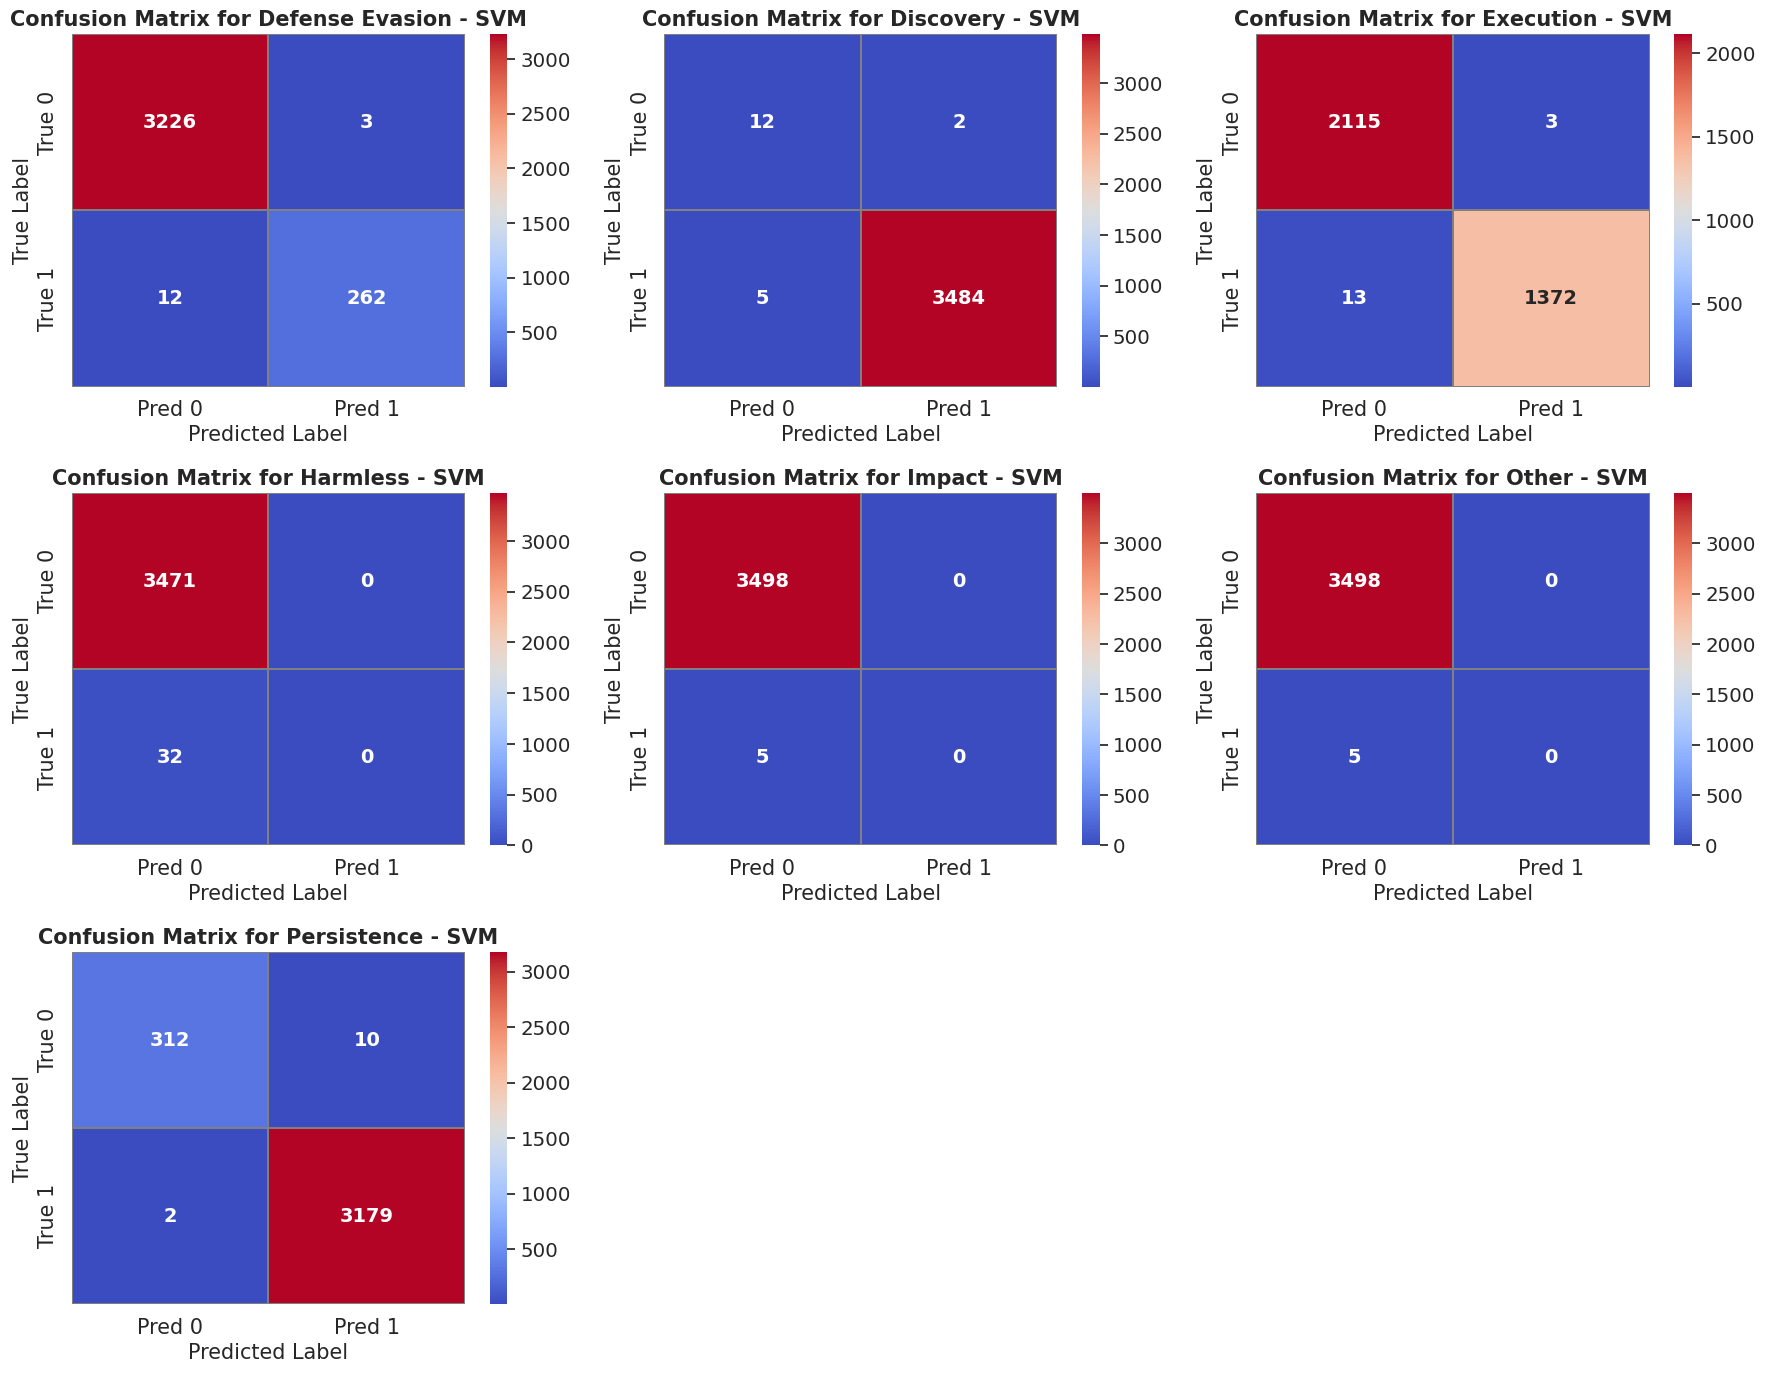

In [55]:
# Train and evaluate SVM
model_name = "SVM"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Compare performances

"Do you observe overfitting or under-fitting? Which model generates the best performance?"

- text
- text

In [56]:
def compare_performances(model_results, X_train, X_test, y_train_binary, y_test_binary):
    """
    Confronta le performance di più modelli utilizzando accuratezza, F1-score, precisione e recall.
    Aggiunge anche una colonna per identificare se il modello è affetto da overfitting.
    
    Args:
        model_results: Un dizionario dei risultati della funzione `train_and_evaluate`.
        X_train, X_test: Dati di addestramento e test.
        y_train_binary, y_test_binary: Etichette binarie per addestramento e test.
    
    Returns:
        Un DataFrame con i risultati dettagliati del confronto per i modelli.
    """
    comparison = []

    for model_name, results in model_results.items():
        model = models[model_name]
        
        # Predici sui dati di addestramento e test
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Allineamento delle predizioni con le etichette
        if y_train_pred.ndim == 1:
            y_train_pred = y_train_pred[:, np.newaxis]
        if y_test_pred.ndim == 1:
            y_test_pred = y_test_pred[:, np.newaxis]
        
        if y_train_pred.shape[1] != y_train_binary.shape[1]:
            y_train_pred = np.hstack([y_train_pred] * y_train_binary.shape[1])
        if y_test_pred.shape[1] != y_test_binary.shape[1]:
            y_test_pred = np.hstack([y_test_pred] * y_test_binary.shape[1])
        
        # Calcola metriche di performance
        train_accuracy = (y_train_pred == y_train_binary).mean().mean()
        test_accuracy = (y_test_pred == y_test_binary).mean().mean()
        
        train_f1 = f1_score(y_train_binary, y_train_pred, average="micro")
        test_f1 = f1_score(y_test_binary, y_test_pred, average="micro")
        
        train_precision = precision_score(y_train_binary, y_train_pred, average="micro")
        test_precision = precision_score(y_test_binary, y_test_pred, average="micro")
        
        train_recall = recall_score(y_train_binary, y_train_pred, average="micro")
        test_recall = recall_score(y_test_binary, y_test_pred, average="micro")
        
        # Calcola overfitting
        overfitting = abs(train_accuracy - test_accuracy)
        overfitting_flag = "Yes" if overfitting > 0.05 else "No"

        # Memorizza i risultati
        comparison.append({
            "Model": model_name,
            "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy,
            "Train F1-Score": train_f1,
            "Test F1-Score": test_f1,
            "Train Precision": train_precision,
            "Test Precision": test_precision,
            "Train Recall": train_recall,
            "Test Recall": test_recall,
            "Overfitting (Accuracy Diff)": overfitting,
            "Overfitting?": overfitting_flag,
        })
    
    # Converti la lista di dizionari in un DataFrame per un confronto più facile
    comparison_df = pd.DataFrame(comparison)
    
    return comparison_df


In [57]:
# Confronta le performance dettagliate
performance_comparison = compare_performances(
    model_results, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

# Visualizza i risultati ordinati per Test Accuracy
performance_comparison.sort_values(by="Test Accuracy", ascending=False)


,Model,Train Accuracy,Test Accuracy,Train F1-Score,Test F1-Score,Train Precision,Test Precision,Train Recall,Test Recall,Overfitting (Accuracy Diff),Overfitting?
1,Random Forest,0.386267,0.383671,0.508016,0.506836,0.350112,0.348658,0.925362,0.927727,0.002596,No
2,SVM,0.386057,0.382978,0.508233,0.507070,0.350158,0.348609,0.926486,0.929638,0.003079,No
0,Logistic Regression,0.379292,0.375311,0.506923,0.505680,0.348168,0.346421,0.931795,0.935969,0.003981,No


<center><b><font size=5>Hyperparameter Tuning<b><center>

Fine-tune the hyperparameters of the ML models using cross-validation.

"Tune the hyper-parameters of the models through cross-validation. How do performance vary?"

**Steps:**

TO BE CHECKED

- Use GridSearchCV or RandomizedSearchCV to tune hyperparameters.
- Evaluate the performance of the tuned models.
- Compare the results with baseline performance.

### text

- text
- text

In [58]:
param_grid_logreg = {
    'estimator__C': [0.1, 1, 10],
    'estimator__solver': ['liblinear', 'saga'],
    'estimator__max_iter': [1000]
}

param_grid_rf = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__random_state': [42]
}

param_grid_svm = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf', 'poly'],
    'estimator__gamma': ['scale', 'auto'],
    'estimator__degree': [3, 4, 5],
    'estimator__random_state': [42]
}

In [59]:
# Funzione per eseguire il GridSearch
def hyperparameter_tuning_with_gridsearch(model_name, model, param_grid, X_train, y_train_binary):
    # Utilizza OneVsRestClassifier per la classificazione multilabel
    ovr_model = OneVsRestClassifier(model)
    
    # Esegui GridSearch solo sui parametri del modello base (RandomForestClassifier)
    grid_search = GridSearchCV(estimator=ovr_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    
    print(f"\nTuning hyperparameters for {model_name}...")
    
    grid_search.fit(X_train, y_train_binary)
    
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")
    
    return grid_search.best_estimator_


In [60]:
# Esegui GridSearch per Logistic Regression con OneVsRestClassifier
best_logreg_model = hyperparameter_tuning_with_gridsearch(
    "Logistic Regression", LogisticRegression(max_iter=1000, random_state=42), param_grid_logreg, X_train_tfidf, y_train_binary
)


Tuning hyperparameters for Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters for Logistic Regression: {'estimator__C': 10, 'estimator__max_iter': 1000, 'estimator__solver': 'liblinear'}
Best cross-validation score for Logistic Regression: 0.9754038179148311


In [61]:
# Esegui GridSearch per Random Forest con OneVsRestClassifier
best_rf_model = hyperparameter_tuning_with_gridsearch(
    "Random Forest", RandomForestClassifier(random_state=42), param_grid_rf, X_train_tfidf, y_train_binary
)


Tuning hyperparameters for Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters for Random Forest: {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 50, 'estimator__random_state': 42}
Best cross-validation score for Random Forest: 0.9794419970631424


In [62]:
best_svm_model = hyperparameter_tuning_with_gridsearch(
    "SVM", models["SVM"], param_grid_svm, X_train_tfidf, y_train_binary
)


Tuning hyperparameters for SVM...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best parameters for SVM: {'estimator__C': 10, 'estimator__degree': 4, 'estimator__gamma': 'scale', 'estimator__kernel': 'poly', 'estimator__random_state': 42}
Best cross-validation score for SVM: 0.9784630445423397


### text

- text
- text

In [63]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Valuta un modello su un set di test, gestisce i warning e visualizza le metriche.
    """
    print(f"\n--- Evaluation for {model_name} ---")

    # Conversione di y_test in array NumPy se è un DataFrame
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    # Predizioni
    y_pred = model.predict(X_test)
    
    # Controllo delle classi predette e reali
    print("Unique predicted classes:", np.unique(y_pred.argmax(axis=1)))
    print("Unique actual classes:", np.unique(y_test.argmax(axis=1)))

    # Matrice di confusione normalizzata
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"{model_name} - Normalized Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Metriche di valutazione
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}\n")

    print("Confusion Matrix (raw):")
    print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("\nClassification Report (per class):")
    print(classification_report(y_test, y_pred, zero_division=0))


--- Evaluation for Logistic Regression ---
Unique predicted classes: [0 1 2 3]
Unique actual classes: [0 1 2 3 4 5]


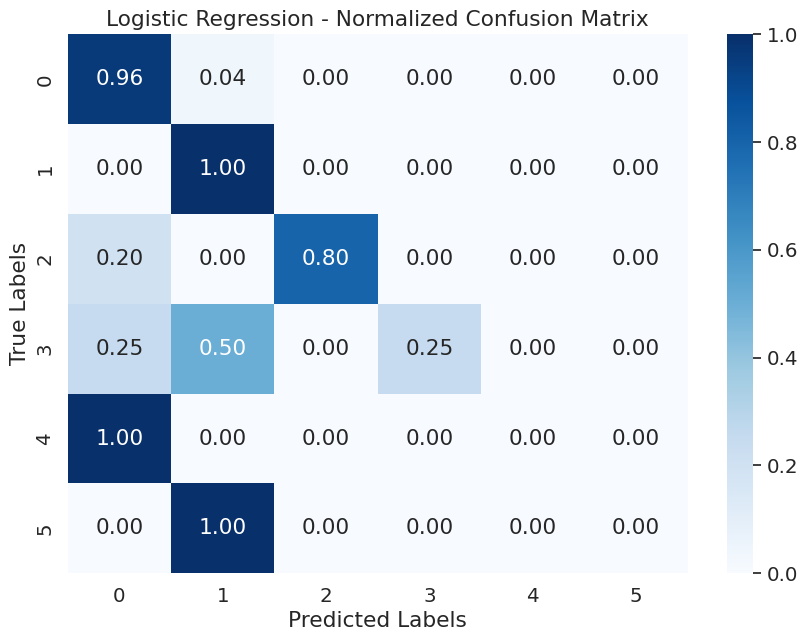

Precision (macro): 0.7115
Recall (macro): 0.5688
F1 Score (macro): 0.5751

Confusion Matrix (raw):
[[ 263   11    0    0    0    0]
 [   3 3213    2    0    0    0]
 [   1    0    4    0    0    0]
 [   1    2    0    1    0    0]
 [   1    0    0    0    0    0]
 [   0    1    0    0    0    0]]

Classification Report (per class):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       274
           1       1.00      1.00      1.00      3489
           2       1.00      0.99      0.99      1385
           3       1.00      0.03      0.06        32
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       1.00      1.00      1.00      3181

   micro avg       1.00      0.99      0.99      8371
   macro avg       0.71      0.57      0.58      8371
weighted avg       1.00      0.99      0.99      8371
 samples avg       1.00      0.99      0.99      8371



In [64]:
# Valutazione dei modelli ottimizzati
evaluate_model(best_logreg_model, X_test_tfidf, y_test_binary, "Logistic Regression")


--- Evaluation for Random Forest ---
Unique predicted classes: [0 1 2 3]
Unique actual classes: [0 1 2 3 4 5]


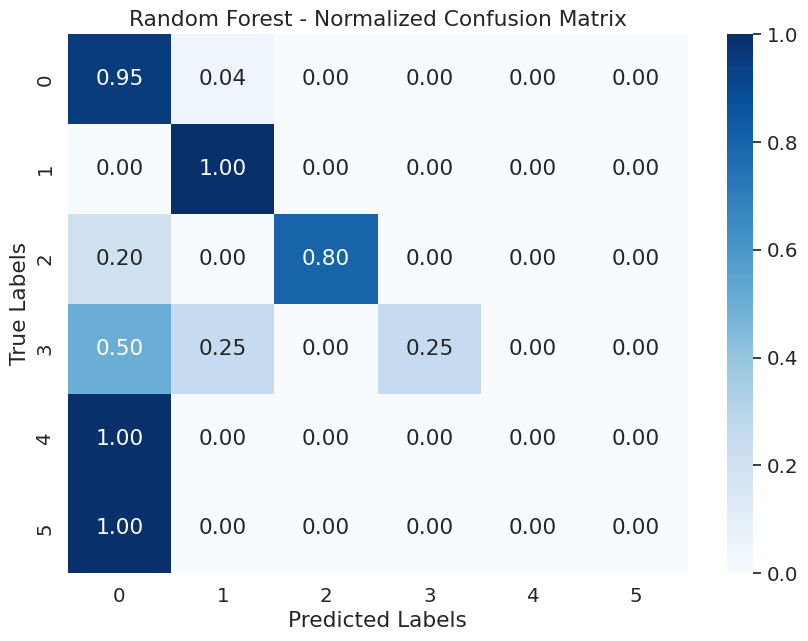

Precision (macro): 0.8553
Recall (macro): 0.6867
F1 Score (macro): 0.7103

Confusion Matrix (raw):
[[ 261   12    1    0    0    0]
 [   2 3216    0    0    0    0]
 [   1    0    4    0    0    0]
 [   2    1    0    1    0    0]
 [   1    0    0    0    0    0]
 [   1    0    0    0    0    0]]

Classification Report (per class):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       274
           1       1.00      1.00      1.00      3489
           2       1.00      0.99      1.00      1385
           3       1.00      0.06      0.12        32
           4       0.00      0.00      0.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00      3181

   micro avg       1.00      0.99      1.00      8371
   macro avg       0.86      0.69      0.71      8371
weighted avg       1.00      0.99      0.99      8371
 samples avg       1.00      0.99      0.99      8371



In [65]:
evaluate_model(best_rf_model, X_test_tfidf, y_test_binary, "Random Forest")


--- Evaluation for SVM ---
Unique predicted classes: [0 1 2 3]
Unique actual classes: [0 1 2 3 4 5]


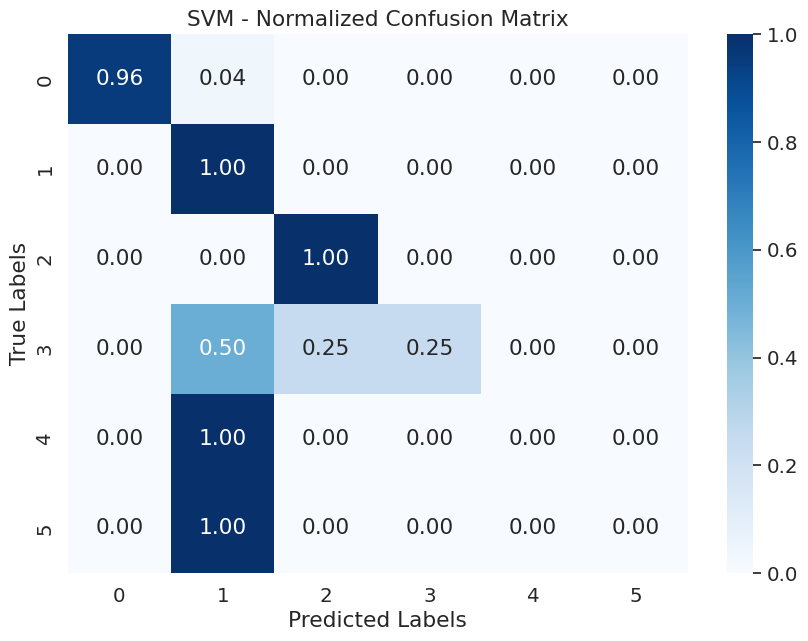

Precision (macro): 0.8263
Recall (macro): 0.6868
F1 Score (macro): 0.6974

Confusion Matrix (raw):
[[ 262   11    1    0    0    0]
 [   3 3215    0    0    0    0]
 [   0    0    5    0    0    0]
 [   0    2    1    1    0    0]
 [   0    1    0    0    0    0]
 [   0    1    0    0    0    0]]

Classification Report (per class):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       274
           1       1.00      1.00      1.00      3489
           2       1.00      0.99      0.99      1385
           3       1.00      0.06      0.12        32
           4       0.00      0.00      0.00         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00      3181

   micro avg       1.00      0.99      1.00      8371
   macro avg       0.83      0.69      0.70      8371
weighted avg       1.00      0.99      0.99      8371
 samples avg       1.00      0.99      0.99      8371



In [66]:
evaluate_model(best_svm_model, X_test_tfidf, y_test_binary, "SVM")

### text

- text
- text

In [67]:
# Funzione per valutare i modelli base e ottimizzati
def compare_models(base_model, tuned_model, X_test, y_test, model_name):
    """
    Confronta le performance di un modello base e di un modello ottimizzato.
    """
    print(f"\n=== {model_name} Comparison ===")
    
    # Conversione di y_test in array NumPy se necessario
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.to_numpy()  # Converti da DataFrame a NumPy array
    y_test = y_test.argmax(axis=1)  # Converti da one-hot encoding a etichette

    # Predizioni per il modello base
    base_pred = base_model.predict(X_test)
    if len(base_pred.shape) > 1:  # Se le predizioni sono in formato one-hot
        base_pred = base_pred.argmax(axis=1)

    base_f1 = f1_score(y_test, base_pred, average='macro', zero_division=0)

    # Predizioni per il modello ottimizzato
    tuned_pred = tuned_model.predict(X_test)
    if len(tuned_pred.shape) > 1:  # Se le predizioni sono in formato one-hot
        tuned_pred = tuned_pred.argmax(axis=1)

    tuned_f1 = f1_score(y_test, tuned_pred, average='macro', zero_division=0)

    print(f"Base Model F1 Score: {base_f1:.4f}")
    print(f"Tuned Model F1 Score: {tuned_f1:.4f}")

    # Plot confronto tra i due
    metrics = ["Precision", "Recall", "F1 Score"]
    base_metrics = [
        precision_score(y_test, base_pred, average='macro', zero_division=0),
        recall_score(y_test, base_pred, average='macro', zero_division=0),
        base_f1
    ]
    tuned_metrics = [
        precision_score(y_test, tuned_pred, average='macro', zero_division=0),
        recall_score(y_test, tuned_pred, average='macro', zero_division=0),
        tuned_f1
    ]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(8, 6))
    plt.bar(x - width/2, base_metrics, width, label="Base Model", color='lightblue')
    plt.bar(x + width/2, tuned_metrics, width, label="Tuned Model", color='orange')
    plt.xticks(x, metrics)
    plt.title(f"{model_name} - Metrics Comparison")
    plt.ylabel("Score")
    plt.legend()
    plt.show()


=== Logistic Regression Comparison ===
Base Model F1 Score: 0.3222
Tuned Model F1 Score: 0.5155


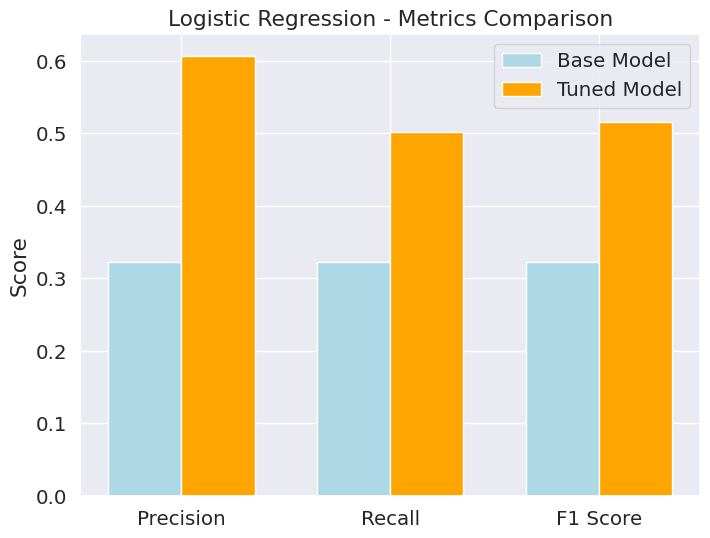

In [68]:
compare_models(models["Logistic Regression"], best_logreg_model, X_test_tfidf, y_test_binary, "Logistic Regression")


=== Random Forest Comparison ===
Base Model F1 Score: 0.3149
Tuned Model F1 Score: 0.5268


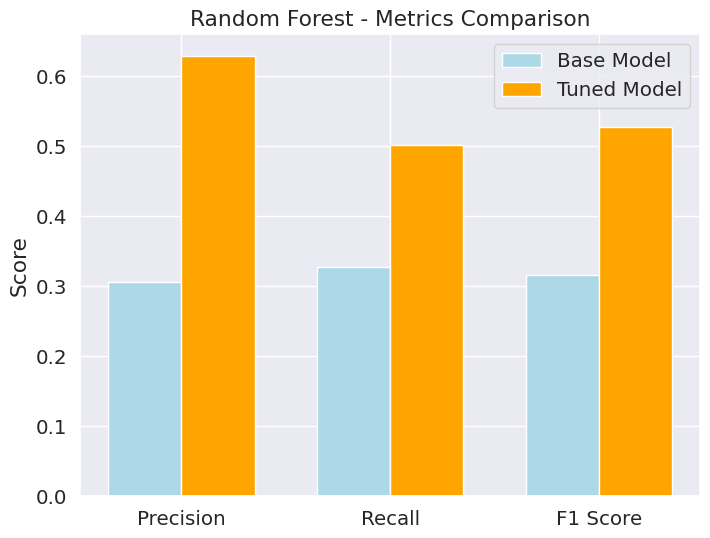

In [69]:
compare_models(models["Random Forest"], best_rf_model, X_test_tfidf, y_test_binary, "Random Forest")


=== SVM Comparison ===
Base Model F1 Score: 0.3143
Tuned Model F1 Score: 0.5338


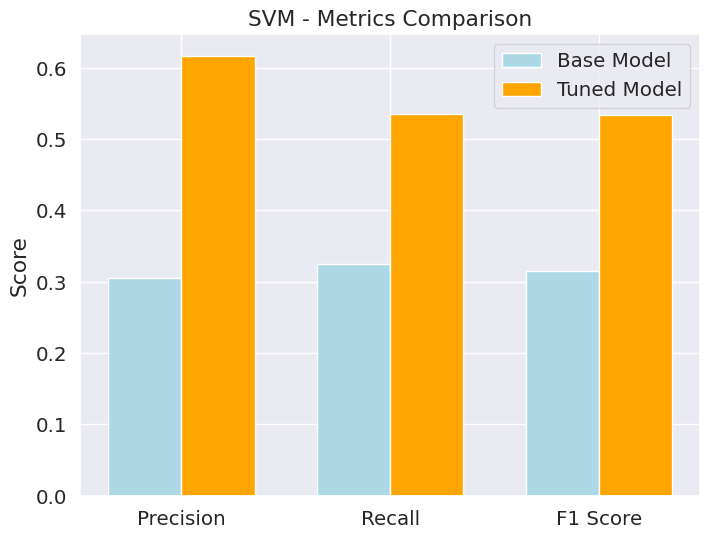

In [70]:
compare_models(models["SVM"], best_svm_model, X_test_tfidf, y_test_binary, "SVM")

<center><b><font size=5>Result Analysis<b><center>

Analyze and summarize the results for each intent.

"Comments on the results for each on the intents."

**Steps:**

- Compare confusion matrices and classification reports.
- Highlight trends and insights for each intent.
- Summarize findings and discuss implications.

### text

- text
- text

### text

- text
- text

### text

- text
- text

<center><b><font size=5>Feature Experimentation<b><center>

Explore the impact of different features on model performance.

"Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen
performance? Think about the problem and summarize the ways you have tried (even those that
did not work)."

**Steps:**

- Experiment with feature combinations (e.g., adding temporal features).
- Observe performance changes with each combination.
- Document successful and unsuccessful experiments.

### text

- text
- text

### text

- text
- text

### text

- text
- text